In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from heapdict import heapdict
from heapq import heappush, heappop
from itertools import count

plt.rcParams["font.family"] = "TakaoPGothic"

## 1対1 最短路

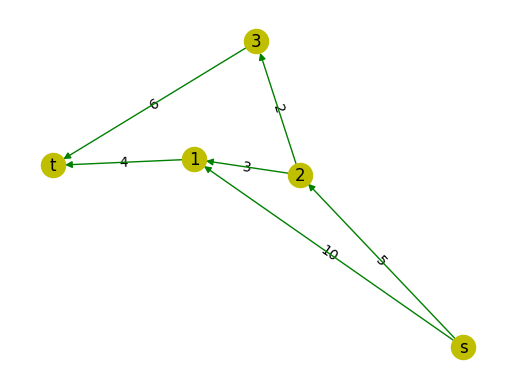

In [ ]:
# グラフの描画
D = nx.DiGraph()
D.add_weighted_edges_from(
    [("s", 1, 10), ("s", 2, 5), (2, 1, 3), (1, "t", 4), (2, 3, 2), (3, "t", 6)]
)
pos = nx.kamada_kawai_layout(D)
nx.draw_networkx_edge_labels(
    D, pos=pos, edge_labels=nx.get_edge_attributes(D, "weight")
)
nx.draw(
    D, node_size=300, pos=pos, node_color="y", edge_color="g", width=1, with_labels=True
)
plt.show()

In [ ]:
# ダイクストラ O((E+V)logV) or O(E + VlogV)
# dijkstra_predecessor_and_distance で最短経路木での直前の頂点と､距離のリストが得られる
pred, distance = nx.dijkstra_predecessor_and_distance(D, source="s")
print(f's -> t shortest distance {distance["t"]}')

# 最短路の復元
path = []
crt = "t"
while crt != "s":
    path += (crt,)
    crt = pred[crt][0]
path += ("s",)
print(" -> ".join([str(n) for n in reversed(path)]))

s -> t shortest distance 12
s -> 2 -> 1 -> t


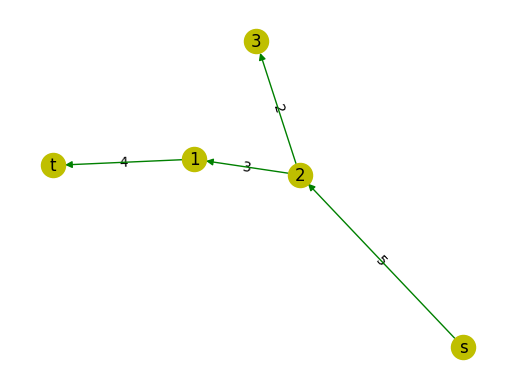

In [ ]:
# 最短経路木を復元
tree = D.edge_subgraph([(pred[v][0], v) for v in D.nodes() if len(pred[v]) > 0])
nx.draw_networkx_edge_labels(
    D, pos=pos, edge_labels=nx.get_edge_attributes(tree, "weight")
)
nx.draw(
    tree,
    node_size=300,
    pos=pos,
    node_color="y",
    edge_color="g",
    width=1,
    with_labels=True,
)
plt.show()

In [ ]:
# m x n のランダムな格子グラフでのテスト
# Dijkstra とA*を比較してみる
#   A*: https://ja.wikipedia.org/wiki/A*
m, n = 1000, 1000
# m, n = 4, 4
lb, ub = 1, 300

RAND = random.Random(1234)
np.random.seed(1234)

G = nx.grid_2d_graph(m, n)
edge_labels = {}
for i, j in G.edges:
    G[i][j]["weight"] = RAND.randint(lb, ub)
    # edge_labels[i,j] = str(G[i][j]['weight'])

# pos = nx.spring_layout(G)
# nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
# nx.draw(G,node_size=100, with_labels=False)
# plt.show()

In [ ]:
## A* の自明なカットオフ
cutoff = sum([G[(i, 0)][(i + 1, 0)]["weight"] for i in range(m - 1)])
cutoff += sum([G[(m - 1, j)][(m - 1, j + 1)]["weight"] for j in range(n - 1)])

In [152]:
%%time
## Dijkstra
pred, distance = nx.dijkstra_predecessor_and_distance(G, source=(0,0))
print(f'Dijkstra {m}x{n} Time distance {distance[(m-1, n-1)]}')

Dijkstra 1000x1000 Time distance 138954
CPU times: user 4.86 s, sys: 9.72 ms, total: 4.87 s
Wall time: 4.87 s


In [ ]:
%%timeit
# A* (何も指定なし)
path = nx.astar_path(G, (0,0), (m-1,n-1))
print(f'A-star {m}x{n} Time')

A-star 1000x1000 Time
A-star 1000x1000 Time
A-star 1000x1000 Time
A-star 1000x1000 Time
A-star 1000x1000 Time
A-star 1000x1000 Time
A-star 1000x1000 Time
A-star 1000x1000 Time
3.66 s ± 398 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [154]:
%%timeit
## A* にカットオフを指定
path = nx.astar_path(G, (0,0), (m-1,n-1), cutoff=cutoff)
print(f'A-star w/ cutoff {m}x{n} Time cutoff {cutoff}')

A-star w/ cutoff 1000x1000 Time cutoff 293606
A-star w/ cutoff 1000x1000 Time cutoff 293606
A-star w/ cutoff 1000x1000 Time cutoff 293606
A-star w/ cutoff 1000x1000 Time cutoff 293606
A-star w/ cutoff 1000x1000 Time cutoff 293606
A-star w/ cutoff 1000x1000 Time cutoff 293606
A-star w/ cutoff 1000x1000 Time cutoff 293606
A-star w/ cutoff 1000x1000 Time cutoff 293606
3.51 s ± 59.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%time
# A* ヒューリスティック関数の前計算
cutoff = sum([G[(i,0)][(i+1,0)]['weight'] for i in range(m-1)])
cutoff += sum([G[(m-1,j)][(m-1,j+1)]['weight'] for j in range(n-1)])
min_col = [min([G[(i,j)][(i,j+1)]['weight'] for i in range(m)]) for j in range(n-1)] + [0]

# 各列､行の最小値の総和をヒューリスティック関数にする
# ヒューリスティック関数は真の値以下(admissible) でなければならない
min_col_suffix_sum = np.cumsum(min_col[::-1])[::-1].tolist()

min_row = [min([G[(i,j)][(i+1,j)]['weight'] for j in range(n)]) for i in range(m-1)] + [0]
min_row_suffix_sum = np.cumsum(min_row[::-1])[::-1].tolist()

print(min_col_suffix_sum)
print(min_row_suffix_sum)

[1029, 1028, 1027, 1026, 1025, 1024, 1023, 1022, 1021, 1020, 1019, 1018, 1017, 1016, 1015, 1014, 1013, 1012, 1011, 1010, 1009, 1008, 1007, 1006, 1005, 1004, 1003, 1002, 1001, 1000, 999, 998, 997, 996, 993, 992, 991, 990, 989, 988, 987, 986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958, 957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944, 943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930, 929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916, 915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902, 901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888, 887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874, 873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860, 859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846, 845, 844, 843, 842, 841, 840, 838, 837, 836, 835, 834, 833, 831,

In [157]:
%%time
## A* にカットオフとヒューリスティックを指定
def heuristic(u, _):
  i, j = u
  # return m-1  - i + n-1 - j
  return min_row_suffix_sum[i] + min_col_suffix_sum[j]
path = nx.astar_path(G, (0,0), (m-1,n-1), heuristic=heuristic, cutoff=cutoff)
print(f'A-star w/ cutoff, heuristic {m}x{n} Time cutoff {cutoff}', cnt)

A-star w/ cutoff, heuristic 1000x1000 Time cutoff 293606 1000000
CPU times: user 3.67 s, sys: 19.9 ms, total: 3.69 s
Wall time: 3.69 s


In [ ]:
# 性能が良くないのはヒューリスティック関数の精度が悪いから?
# 実際のdistanceとヒューリスティックなdistance で大きく差がある
print(f"path length {len(path)}, {path[:10]}...{path[-10:]}")
print(
    f'distance = {sum([G[path[i]][path[i+1]]["weight"] for i in range(len(path) - 1)])}'
)
print(f"heuristic distance = {min_row_suffix_sum[0] + min_col_suffix_sum[0]}")

path length 2071, [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5)]...[(997, 992), (997, 993), (997, 994), (998, 994), (999, 994), (999, 995), (999, 996), (999, 997), (999, 998), (999, 999)]
distance = 138954
heuristic distance = 2059


In [ ]:
# A* で厳密なヒューリスティックが分かっているときにどうなるか
pred, distance = nx.dijkstra_predecessor_and_distance(G, source=(m - 1, n - 1))
print(f"Dijkstra {m}x{n} Time distance")

Dijkstra 1000x1000 Time distance


In [164]:
%%time
cnt = 0
def heuristic(u, _):
  global cnt, distance
  cnt += 1
  return distance[u]
path = nx.astar_path(G, (0,0), (m-1,n-1), heuristic=heuristic, cutoff=cutoff)
print(f'A-star w/ exact h {m}x{n} Time, cutoff={cutoff}, # of calling heuristic function={cnt}')

A-star w/ exact h 1000x1000 Time, cutoff=293606, # of calling heuristic function=5229
CPU times: user 10.6 ms, sys: 6 μs, total: 10.7 ms
Wall time: 10.6 ms


In [119]:
%%time
# 双方向ダイクストラ
length, path = nx.bidirectional_dijkstra(G,(0,0), (m-1,n-1))

CPU times: user 26 s, sys: 1.37 s, total: 27.4 s
Wall time: 27.4 s


## 1対全 最短路問題

In [ ]:
# m x n のランダムな格子グラフでのテスト
import random

m, n = 10, 10
lb, ub = 1, 300

RAND = random.Random(1234)
np.random.seed(1234)

G = nx.grid_2d_graph(m, n)
edge_labels = {}
for i, j in G.edges:
    G[i][j]["weight"] = RAND.randint(lb, ub)
pos = {(i, j): (i, j) for (i, j) in G.nodes()}

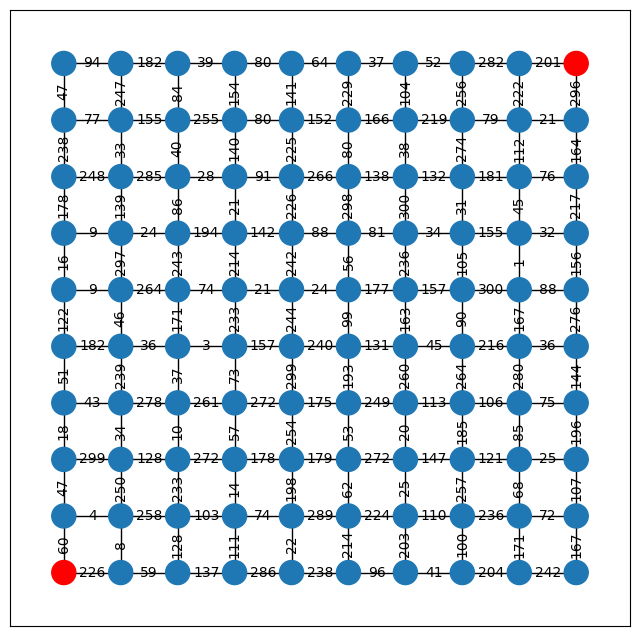

In [ ]:
# グラフの描画
edge_labels = {}
for u, v in G.edges():
    edge_labels[(u, v)] = str(G[u][v]["weight"])

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=[
        "#1f78b4" if v != (0, 0) and v != (m - 1, n - 1) else "red" for v in G.nodes()
    ],
)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
nx.draw_networkx_edges(G, pos=pos)
plt.show()

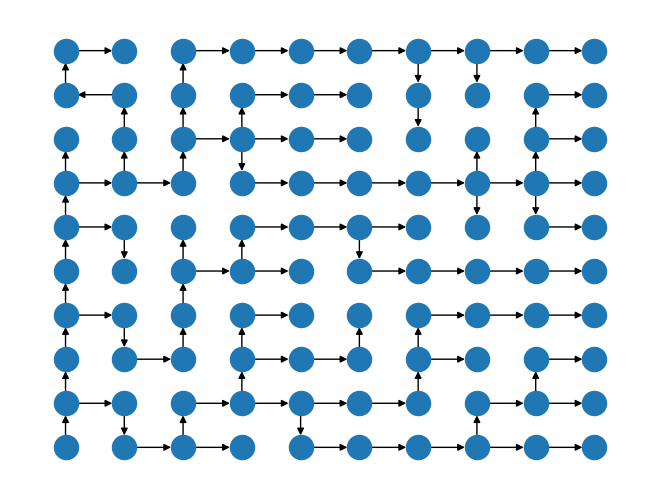

In [ ]:
# Dijkstraの実行と最短経路木の構築
pred, distance = nx.dijkstra_predecessor_and_distance(G, source=(0, 0))
D = nx.DiGraph()
for i in pred:
    if len(pred[i]) >= 1:
        D.add_edge(pred[i][0], i)
plt.figure()
nx.draw(D, pos=pos)
plt.show()

## 枝の費用が負のものがある場合

In [ ]:
# ランダムな格子のグラフを作成
# m, n = 5, 5
m, n = 50, 50
ub = 100
G = nx.grid_2d_graph(m, n)
D = G.to_directed()

RAND = random.Random(1234)
if False:  # test
    for i, j in D.edges():
        D[i][j]["weight"] = 10
    for i in range(m - 1):
        D[(i, 0)][(i + 1, 0)]["weight"] = -1
        D[(i + 1, n - 1)][(i, n - 1)]["weight"] = -1
    for j in range(n - 1):
        D[(m - 1, j)][(m - 1, j + 1)]["weight"] = -1
        D[(0, j + 1)][(0, j)]["weight"] = -1
else:
    for i, j in D.edges():
        if i < j:
            w = RAND.randint(1, ub)
            sign = RAND.randint(0, 1) * 2 - 1
            D[i][j]["weight"] = w * sign
            if sign < 0:
                D[j][i]["weight"] = RAND.randint(w, ub)
            else:
                D[j][i]["weight"] = RAND.randint(1, w) * (RAND.randint(0, 1) * 2 - 1)

pos = {(i, j): (i, j) for (i, j) in D.nodes()}

In [ ]:
if m * n <= 100:
    edge_labels = nx.get_edge_attributes(D, "weight")
    plt.figure(figsize=(8, 8))
    nx.draw(D, pos, connectionstyle="arc3,rad=0.3", with_labels=True)
    nx.draw_networkx_edge_labels(
        D, pos, connectionstyle="arc3,rad=0.3", edge_labels=edge_labels
    )
    plt.show()
#  [(3, 2), (4, 2), (4, 3), (3, 3)]

In [175]:
%%time
# ベルマンフォード O(VE)
pred, distance = {}, {}
try:
  pred, distance = nx.bellman_ford_predecessor_and_distance(D, source=(0,0), heuristic=False)
except nx.NetworkXUnbounded as e:
  print(e)

Negative cycle detected.
CPU times: user 8.57 s, sys: 0 ns, total: 8.57 s
Wall time: 8.57 s


In [176]:
%%time
# goldberg_radzik O(VE)
pred, distance = {}, {}
try:
  pred, distance = nx.goldberg_radzik(D, source=(0,0))
except nx.NetworkXUnbounded as e:
  print(e)


Negative cycle detected.
CPU times: user 5.58 ms, sys: 55 μs, total: 5.64 ms
Wall time: 5.59 ms


### goldberg_radzik

- [論文](https://www.sciencedirect.com/science/article/pii/089396599390022F)
- 時間計算量はベルマンフォードと同じ$O(|V||E|) = O(nm)$
- ヒューリスティックな方法で典型的には負閉路検出が早くできる
- dijkstra と似たような方法｡$B=\{s\}, d(s)=0, d(V-\{s\})=\inf$ として以下を繰り返す
    - Bから辺をたどり距離関数dが改善できた頂点を列挙してAとする
    - 辺Eのうち距離関数dが更新できるものだけ残した部分グラフ(reduced Graph $G_d$ := $\{(u,v) \in E \mid w_{uv} + d(u) - d(v) < 0\}$) を作る
    - $G_d$ の中でAをトポロジカルソートする｡閉路があれば｢負閉路あり｣
    - 閉路がなければ､その順序でAに接続する頂点を更新する｡更新できた頂点を新たにBとする

In [ ]:
# verified by https://onlinejudge.u-aizu.ac.jp/courses/library/5/GRL/1/GRL_1_B

import sys

sys.setrecursionlimit(10**6)


def goldberg_radzik(G, s):
    d = {}
    parent = {}
    for v in G.nodes():
        d[v] = np.inf

    d[s] = 0

    B = {s}
    iter = 0
    while len(B) > 0:
        iter += 1

        A = set()
        del_list = []
        for v in B:
            updated = False
            for w in G[v]:
                cost = G[v][w]["weight"]
                if cost + d[v] < d[w]:  # admissible
                    d[w] = cost + d[v]
                    parent[w] = v
                    A.add(w)
                    updated = True
            if not updated:
                del_list.append(v)

        # topo sort
        neg_loop_start = None

        def dfs(v, visited, topo_list):
            nonlocal neg_loop_start

            if v in visited:
                if visited[v] == 1:
                    return False
            else:
                visited[v] = 1
                for w in G[v]:
                    cost = G[v][w]["weight"]
                    if cost + d[v] < d[w]:  # admissible
                        parent[w] = v
                        d[w] = cost + d[v]
                        if not dfs(w, visited, topo_list):
                            if neg_loop_start is None:
                                neg_loop_start = v
                            return False
                visited[v] = 0
                topo_list.append(v)
            return True

        visited = {}
        topo_list = []
        is_dag = True
        for v in A:
            if not v in visited:
                is_dag = is_dag and dfs(v, visited, topo_list)

        if not is_dag:
            stacktrace = [neg_loop_start]
            v = parent[neg_loop_start]
            while v != neg_loop_start:
                stacktrace.append(v)
                v = parent[v]
            raise Exception(f"Negative cycle detected. {stacktrace}")
        topo_list.reverse()

        # scan
        B = set()
        for v in topo_list:
            for w in G[v]:
                cost = G[v][w]["weight"]
                if d[v] + cost < d[w]:  # admissible
                    parent[w] = v
                    d[w] = d[v] + cost
                    B.add(w)

        if iter > 20:
            raise
    return d

In [128]:
%%time
try:
  d = goldberg_radzik(D, (0, 0))
  print(d[(m-1, n-1)])
except Exception as e:
  print(e)

Negative cycle detected. [(11, 49), (10, 49), (9, 49), (8, 49), (7, 49), (6, 49), (5, 49), (4, 49), (3, 49), (2, 49), (1, 49), (0, 49), (0, 48), (1, 48), (2, 48), (3, 48), (4, 48), (5, 48), (6, 48), (7, 48), (8, 48), (9, 48), (10, 48), (11, 48)]
CPU times: user 7.27 ms, sys: 0 ns, total: 7.27 ms
Wall time: 7.08 ms


## 全対全の最短路

In [ ]:
from collections import defaultdict

m, n = 20, 20
lb, ub = 1, 100
G = nx.grid_2d_graph(m, n)
for i, j in G.edges():
    G[i][j]["weight"] = random.randint(lb, ub)

## johnson

- ダイクストラをV回やる｡O(V x (E+VlogV))
- 負辺があるときはいい感じにバイアスをいれて正の辺にする
- https://noshi91.github.io/algorithm-encyclopedia/johnson-algorithm


In [104]:
%%time
jo_paths = None
try:
    jo_paths = nx.johnson(G)
except nx.NetworkXUnbounded as e:
    print(e)

CPU times: user 587 ms, sys: 0 ns, total: 587 ms
Wall time: 586 ms


In [105]:
%%time
## Warshall Floyd, O(V^3)
wa_dists = defaultdict(lambda: {})
wa_parent = defaultdict(lambda: {})

V = G.nodes()
for u in V:
  for v in V:
    wa_dists[u][v] = np.inf
  wa_dists[u][u] = 0

  for v in G[u]:
    wa_dists[u][v] = G[u][v]['weight']
    wa_parent[u][v] = u

for w in V:
  for u in V:
    for v in V:
      new_dist = wa_dists[u][w] + wa_dists[w][v]
      if new_dist < wa_dists[u][v]:
        wa_dists[u][v] = new_dist
        wa_parent[u][v] = wa_parent[w][v]

# path の復元
wa_paths = defaultdict(lambda: {})
if True:
  for u in V:
    for v in V:
      if v not in wa_paths[u]:
        path = []
        crt = v
        while crt != u:
          path.append(crt)
          crt = wa_parent[u][crt]
        path.append(u)
        path.reverse()

        wa_paths[u][v] = path

        while len(path) > 0:
          wa_paths[u][path[-1]] = path.copy()
          path.pop()

CPU times: user 12 s, sys: 0 ns, total: 12 s
Wall time: 12 s


In [ ]:
# パスが一致するかチェック
V = G.nodes()

for u in V:
    for v in V:
        jo_path = jo_paths[u][v]
        wa_path = wa_paths[u][v]
        jo_len = 0
        for i in range(len(jo_path) - 1):
            jo_len += G[jo_path[i]][jo_path[i + 1]]["weight"]
        wa_len = 0
        for i in range(len(wa_path) - 1):
            wa_len += G[wa_path[i]][wa_path[i + 1]]["weight"]

        if jo_len != wa_len:
            print(u, v, jo_len, wa_len)
            raise "wrong paths"

### 道路ネットワークの最短路と前処理による高速化

In [27]:
import requests
import pprint

# 前処理Highway Hierarchy を使用して､地図探索を高速化しているアプリの例
response = requests.get(
    "http://router.project-osrm.org/route/v1/driving/139.792429,35.667864;139.768525,35.681010"
)
j = response.json()
pprint.pprint(j)

{'code': 'Ok',
 'routes': [{'distance': 3196.2,
             'duration': 364.1,
             'geometry': 'ujuxEaeftY{DxEe@k@m@t@hQfWoInJ_YrFeQjOeGxLeAzGkVtw@cAk@e@x@',
             'legs': [{'distance': 3196.2,
                       'duration': 364.1,
                       'steps': [],
                       'summary': '',
                       'weight': 364.1}],
             'weight': 364.1,
             'weight_name': 'routability'}],
 'waypoints': [{'distance': 12.447895405,
                'hint': '5G0OgfltDoG2AAAAFAAAAAAAAADRAAAAPbyYQmiT_UAAAAAA_ratQrYAAAAUAAAAAAAAANEAAADzZAAAyQ9VCEs_IAItEFUImD8gAgAAjwj_YX0r',
                'location': [139.792329, 35.667787],
                'name': ''},
               {'distance': 32.442884557,
                'hint': 'otddh____38GAAAABgAAAB8AAAAdAAAAiWQVQAAAAAA04ExBZKhCQQYAAAAGAAAAHwAAAB0AAADzZAAAF7RUCIByIALNslQI8nIgAgEAXxX_YX0r',
                'location': [139.768855, 35.680896],
                'name': 'タクシー・一般車降車場(一般車用)'}]}


In [ ]:
# 距離と時間だけ抽出
print(
    f'distance={j["routes"][0]["distance"]}m, duration={j["routes"][0]["duration"]} seconds'
)

distance=3196.2m, duration=364.1 seconds


In [ ]:
# 複数の場所を指定すると全対の最短路を計算する
locations = [(13.388860, 52.517037), (13.397634, 52.529407), (13.428555, 52.523219)]
query = ";".join([f"{location[0]},{location[1]}" for location in locations])
response = requests.get(
    f"http://router.project-osrm.org/table/v1/driving/{query}"
    + "?annotations=distance,duration"
)
jj = response.json()
pprint.pprint(j)

{'code': 'Ok',
 'destinations': [{'distance': 4.231521214,
                   'hint': 'm_sJgOkknIUXAAAABQAAAAAAAAAgAAAAIXRPQYXNK0AAAAAAcPePQQsAAAADAAAAAAAAABAAAAA8DAEA_kvMAKlYIQM8TMwArVghAwAA7woD96zE',
                   'location': [13.388798, 52.517033],
                   'name': 'Friedrichstraße'},
                  {'distance': 2.795148358,
                   'hint': 'BxfegfYUjYcGAAAACQAAAAAAAAB3AAAAppONQCyhu0AAAAAA1J-EQgYAAAAJAAAAAAAAAHcAAAA8DAEAfm7MABiJIQOCbswA_4ghAwAAXwUD96zE',
                   'location': [13.39763, 52.529432],
                   'name': 'Torstraße'},
                  {'distance': 2.226580806,
                   'hint': 'oiUYgP___38fAAAAUQAAACYAAABSAAAAeosKQlNOX0Ki6yZCakq4Qh8AAABRAAAAJgAAAFIAAAA8DAEASufMAOdwIQNL58wA03AhAwQAvxAD96zE',
                   'location': [13.428554, 52.523239],
                   'name': 'Platz der Vereinten Nationen'}],
 'distances': [[0, 1886.8, 3804], [1903, 0, 2845.2], [3279.7, 2292.2, 0]],
 'durations': [[0, 260.3, 389.5], [2

In [ ]:
n = len(locations)
dests = [jj["sources"][i]["name"] for i in range(n)]
for j in range(n):
    for i in range(j):
        print(f'distance from {dests[i]} to {dests[j]} is {jj["distances"][i][j]}')

distance from Friedrichstraße to Torstraße is 1886.8
distance from Friedrichstraße to Platz der Vereinten Nationen is 3804
distance from Torstraße to Platz der Vereinten Nationen is 2845.2


### Hiway Hierarchy

- 元のグラフに適当な前処理をして疎なグラフを作っておき､疎なグラフ上で探索をすることで高速にクエリを返せるようにする
- Dijkstraで優先度つきキューから取り出される順番を**Dijkstraランク**とする
- 始点sとパラメータHが与えられたときに､ランクH番目の頂点への距離以下の頂点集合を$N_H(s)$ で表す
- ある終点tに向かう最短路上の辺(v,w)のうち､$v \not \in N_H(t)$ かつ $w \not \in N_H(s)$ のものを集める
  - $N_H(s), N_H(t)$ が作る集合をs,tを中心とする円とイメージすると良い
- そこから次数2以上の頂点だけ抽出し､次数2の点を縮約したグラフを生成
- これを複数回繰り返して何層かのグラフを作る

## Dial法によるベンチマーク

### Dial法

- 辺のコストの最大値が小さいときに計算量が小さいアルゴリズム
  - アイディアはBFSや0-1 BFSを一般化したもの
- 時間計算量は$O(|E|+C|V|)$, ただしCは辺のコストの最大値
- 概要
  - 双方向リストをC|V|個用意
    - ある頂点vが距離dで到達できるとき､d番目のリストに入っている
    - 最初は開始頂点だけ0番目に､それ以外の頂点は一番最後のリストに入れる
  - リストを順番に見ていき､頂点vを取り出す
  - 頂点vから到達できる頂点wで､元の距離dからより小さい距離d'に更新できる点があったら､d番目のリストからd'番目へ移動させる
- 各辺がちょうど一回なめられるため頂点を移動させる回数は$O(|E|)$
- リストは高々$O(C|V|)$回アクセスされる
- 頂点の移動は$O(1)$でできるので､時間計算量は$O(|E|+C|V|)$

In [151]:
import networkx as nx
import osmnx as ox

ox.__version__

'1.9.4'

In [204]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("Kawasaki, Kanagawa, Japan", network_type="drive")

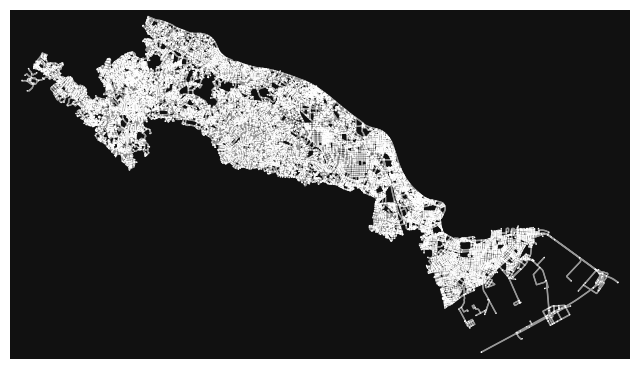

In [165]:
fig, ax = ox.plot_graph(G, node_size=1)

In [206]:
D = ox.convert.to_digraph(G)
D.number_of_nodes(), D.number_of_edges()

(23205, 62733)

In [ ]:
def DialSub(n, G, settled, reached, dist, prev, C, source, sink):
    """Dial method subroutine"""
    circular = [[-1] for i in range(C)]  # -1 represents the list is empty
    circular[0].append(source)
    reached[source] = 1
    prev[source] = -1
    current = 0
    while 1:
        first = current
        while 1:
            v = circular[current][-1]  # v is the node with minimum potential
            if v >= 0:
                break
            # the current list is empty, so we increment it
            current += 1
            current = current % C
            if current == first:
                # the circular list is empty, so we quit
                v = -1
                break

        if v == -1:  # the circular list is empty, so we quit
            break
        circular[current].pop()
        settled[v] = 1
        if v == sink:
            break

        for w in G.neighbors(v):  # scan operation
            if settled[w] == 0:
                temp = dist[v] + G[v][w]["length"]
                if reached[w] == 0:  # w is not in the circular list
                    reached[w] = 1
                    dist[w] = temp
                    prev[w] = v
                    circular[temp % C].append(w)
                else:  # w is in the circular list
                    if temp < dist[w]:
                        circular[dist[w] % C].remove(w)
                        circular[temp % C].append(w)
                        dist[w] = temp
                        prev[w] = v

In [ ]:
from collections import defaultdict

n, m, C = D.number_of_nodes(), D.number_of_edges(), 0
G = D

# 辺を整数に切り落としておく
for v in G.nodes:
    # print(f'vertex {v} is {G.nodes[v]}')
    for e in G[v]:
        # print(f'edge {e} is {G[v][e]}')
        G[v][e]["length"] = int(G[v][e]["length"])
w = nx.get_edge_attributes(G, "length")
C = max([int(l) for l in w.values()]) + 1
print(G)
print("max length+1=", C)


source = list(G.nodes.keys())[0]
sink = list(G.nodes.keys())[
    -1
]  # if sink =-1 then find all shortest paths from source to other nodes

settled = defaultdict(int)
reached = defaultdict(int)  # =1 if node is heap or list (or has a finite potential)
dist = defaultdict(int)
prev = defaultdict(int)

# settled = [0 for i in range(n)]
# reached = [0 for i in range(n)]
# dist = [0 for i in range(n)]
# prev = [0 for i in range(n)]

DiGraph with 23205 nodes and 62733 edges
max length+1= 3250


Dijkstra と比較

In [116]:
%%time
print('Dial法')
DialSub(n,G,settled,reached,dist,prev,C,source,sink)

Dial法
CPU times: user 31.3 ms, sys: 0 ns, total: 31.3 ms
Wall time: 31.1 ms


In [117]:
%%time
print('dijkstra_path_length')
length=nx.dijkstra_path_length(G,source,sink,weight='length')
dist[sink], length

dijkstra_path_length
CPU times: user 23.2 ms, sys: 0 ns, total: 23.2 ms
Wall time: 22.8 ms


(22240, 22240)

In [155]:
%%time
print('dijkstra_predecessor_and_distance')
pred, distance = nx.dijkstra_predecessor_and_distance(G, source=source, weight='length')

dijkstra_predecessor_and_distance
CPU times: user 96.6 ms, sys: 0 ns, total: 96.6 ms
Wall time: 95.8 ms


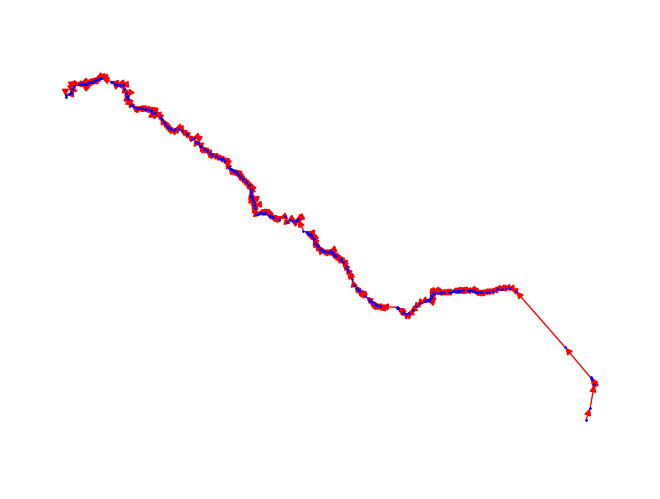

In [ ]:
# 最短路だけ描画
subg = nx.DiGraph()
path = [sink]
cur = sink
while cur != source:
    cur = pred[cur][0]
    path.append(cur)

path.reverse()
subg = nx.DiGraph()
nx.add_path(subg, path)
pos = {}
for v in path:
    pos[v] = (G.nodes[v]["x"], G.nodes[v]["y"])

nx.draw(
    subg,
    pos=pos,
    node_size=1,
    with_labels=None,
    width=1,
    node_color="b",
    edge_color="r",
)
plt.show()

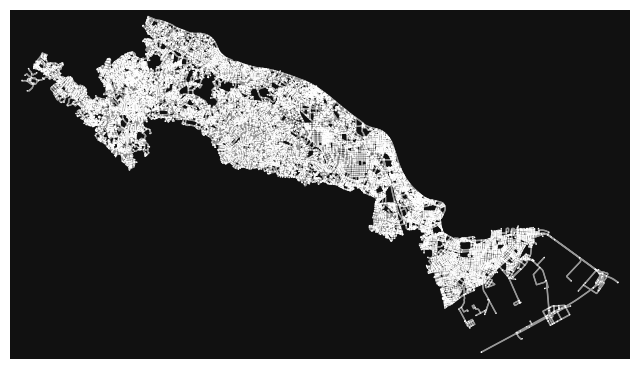

In [ ]:
fig, ax = ox.plot_graph(G, node_size=1)

## 最短路ヒープの比較

- Dijkstraで優先度つきキューを使うとき､キーの値は単調に減少する
  - ある同じキーkに対して順番に値v1,v2,v3,... が追加されるならば､v1 >= v2 >= v3 >= ... が成り立つ
- 優先度つきキューに入ったキーk の値を小さくする'decrease-key' が使用可能
- キーを追加･削除するより高速
  - ただし計算量は変わらない
- Python の標準で用意される優先度つきキューは､decrease-key が用意されていない

In [211]:
%%time
# heapq を使用したDijkstra実装
weight='weight'
get_weight = lambda u, v, data: data.get(weight, 1)
G_succ = G.succ if G.is_directed() else G.adj
pred = {source: []} 
paths={source: [source]} 

push = heappush
pop = heappop
dist = {}  # dictionary of final distances
seen = {source: 0}
c = count()
fringe = []  # use heapq with (distance,label) tuples
push(fringe, (0, next(c), source))
while fringe:
    (d, _, v) = pop(fringe)
    if v in dist:
        continue  # already searched this node.
    dist[v] = d
    if v == sink:
        break

    for u, e in G_succ[v].items():
        cost = get_weight(v, u, e)
        if cost is None:
            continue
        vu_dist = dist[v] + get_weight(v, u, e)
        if u in dist:
            if vu_dist < dist[u]:
                raise ValueError('Contradictory paths found:',
                                 'negative weights?')
        elif u not in seen or vu_dist < seen[u]:
            seen[u] = vu_dist
            push(fringe, (vu_dist, next(c), u))
            if paths is not None:
                paths[u] = paths[v] + [u]
            if pred is not None:
                pred[u] = [v]
        elif vu_dist == seen[u]:
            if pred is not None:
                pred[u].append(v)
dist[sink]

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 133 ms


149

In [212]:
%%time
# heapdict を使用したDijkstra実装
weight='weight'
get_weight = lambda u, v, data: data.get(weight, 1)
G_succ = G.succ if G.is_directed() else G.adj
pred = {source: []} 
paths={source: [source]} 

dist = {} # dictionary of final distances
hd = heapdict()
seen = {source: 0}
c = count()
hd[source] = 0
dist
while hd:
    (v, d) = hd.popitem()
    # decrease-keyの場合には以下が不要
    #if v in dist:
    #    continue  # already searched this node. 
    dist[v] = d
    if v == sink:
        break

    for u, e in G_succ[v].items():
        cost = get_weight(v, u, e)
        if cost is None:
            continue
        vu_dist = dist[v] + get_weight(v, u, e)
        if u in dist:
            if vu_dist < dist[u]:
                raise ValueError('Contradictory paths found:',
                                 'negative weights?')
        elif u not in seen or vu_dist < seen[u]:
            seen[u] = vu_dist
            #push(fringe, (vu_dist, next(c), u))
            hd[u] = vu_dist
            if paths is not None:
                paths[u] = paths[v] + [u]
            if pred is not None:
                pred[u] = [v]
        elif vu_dist == seen[u]:
            if pred is not None:
                pred[u].append(v)
dist[sink]

CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 114 ms


149

### 時刻依存の移動時間をもつ最短路問題

In [ ]:
interval = [0, 4, 8, 10]  # time interval
# interval = [0, 4, 8, 10]  # time interval
v = [10, 20, 30, 20]  # velocity
# v = [16, 20, 45, 20]  # velocity
distance = 10
# distance = 100

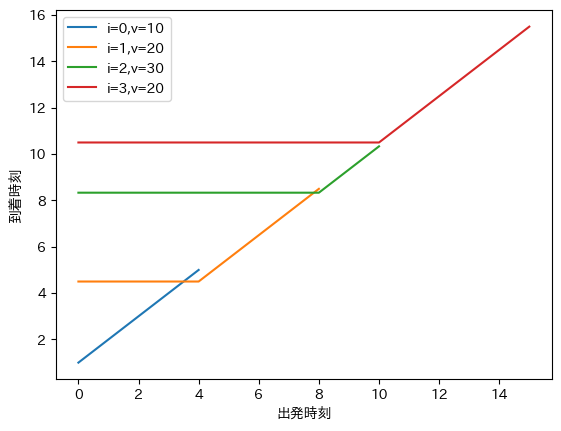

In [ ]:
# 各区間ごとの到着時刻関数
# 到着時刻関数は､各プロットの最小値に相当する
for i in range(len(interval) - 1):
    s, t = interval[i], interval[i + 1]
    move_time = distance / v[i]
    plt.plot(
        [0, s, t],
        [s + move_time, s + move_time, t + move_time],
        label=f"i={i},v={v[i]}",
    )
else:
    s = interval[-1]
    move_time = distance / v[-1]
    limit = 5
    plt.plot(
        [0, s, s + limit],
        [s + move_time, s + move_time, s + limit + move_time],
        label=f"i={len(interval) - 1},v={v[-1]}",
    )

plt.xlabel("出発時刻")
plt.ylabel("到着時刻")
plt.legend()
plt.show()

In [ ]:
from typing import List, Tuple


def arrival_func(
    interval: List[float], velocity: List[float], distance: float
) -> Tuple[List[float], List[float], List[float]]:
    """到達時刻関数を計算するためのパラメータを返す

    Args:
      interval (List[float]): 速度が変化する時刻
      velocity (List[float]): 変化した後の速度
      distance (float): 移動距離

    Returns:
      Tuple[List[float], List[float], List[float]]: 以下を満たす(iv, b, a) を返す｡

      - iv は0から始まる単調増加な列
      - a は0か1
      - 時刻tに出発するとき iv[i] <= t < iv[i+1] を満たすi が存在するとき到着時刻は b[i] + a[i] * (t - iv[i]) で表される

    Note:
      雑実装のためO(N^2)で計算している.工夫すればO(NlogN)かO(N)でできそう?
    """
    assert len(interval) == len(
        velocity
    ), "length of interval and velocity should be the same."
    assert interval[0] == 0, "interval should start with 0"

    def push0(iv, a, b, x0, x1, new_b):
        while len(iv) > 1:
            last_a = a[-1]
            last_b = b[-1]
            last_x0 = iv[-2]
            last_x1 = iv[-1]

            if last_x1 <= x0:
                break

            if last_a == 0:
                if last_b <= new_b:
                    break
                else:
                    if last_x0 < x0:
                        iv[-1] = x0
                        break
                    else:
                        iv.pop()
                        a.pop()
                        b.pop()
            else:
                dx = new_b - last_b
                x = last_x0 + dx
                if last_x1 <= x:
                    break
                elif last_x0 < x:
                    iv[-1] = x
                    break
                else:
                    iv.pop()
                    a.pop()
                    b.pop()

        if iv[-1] < x1:
            a.append(0)
            b.append(new_b)
            iv.append(x1)

    n = len(interval)
    iv = [0, interval[1]]
    a = [1]
    b = [distance / velocity[0]]
    for i in range(1, n):
        new_b = interval[i] + distance / velocity[i]
        # print(f'push0 {i=}, {new_b=}, {iv=}, {a=}, {b=}')
        push0(iv, a, b, 0, interval[i], new_b)
        # print(f'push0 result {new_b=}, {iv=}, {a=}, {b=}')

        if i + 1 < n:
            iv.append(interval[i + 1])
            a.append(1)
            b.append(new_b)
    a.append(1)
    b.append(interval[-1] + distance / velocity[-1])
    return (iv, b, a)

In [30]:
iv, b, a = arrival_func(interval, v, distance)
print(iv, b, a)

[0, 3.5, 4, 7.833333333333334, 8, 10] [1.0, 4.5, 4.5, 8.333333333333334, 8.333333333333334, 10.5] [1, 0, 1, 0, 1, 1]


In [ ]:
def arrival(t, iv, b, a):
    for i in range(len(iv) - 1):
        if iv[i] <= t < iv[i + 1]:
            return b[i] + a[i] * (t - iv[i])
    else:
        return b[-1] + a[-1] + (t - iv[-1])

In [32]:
# 到着時刻関数
t = 0
while t < 15:
    print(t, arrival(t, iv, b, a))
    t += 1
    # t += 0.25

0 1.0
1 2.0
2 3.0
3 4.0
4 4.5
5 5.5
6 6.5
7 7.5
8 8.333333333333334
9 9.333333333333334
10 11.5
11 12.5
12 13.5
13 14.5
14 15.5


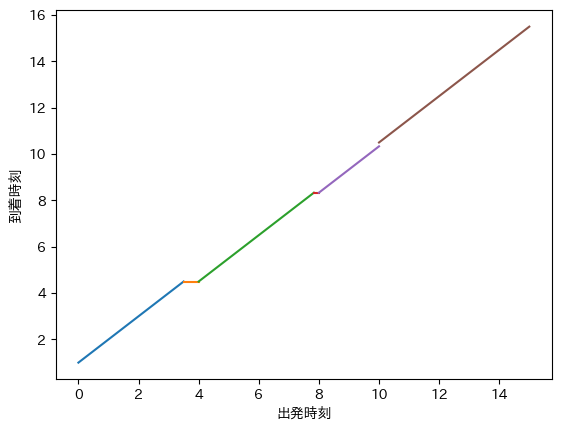

In [ ]:
# 到着時刻関数をプロット
# Webページと形が違うが､元のplot_arrival 関数が間違っている(不連続性を考慮せずプロットしている)
def plot_arrival(iv, b, a):
    for i in range(len(iv) - 1):
        s, t = iv[i], iv[i + 1]
        plt.plot([s, t], [b[i], b[i] + a[i] * (t - s)])
    else:
        s = iv[-1]
        limit = 5
        plt.plot([s, s + limit], [b[-1], b[-1] + a[-1] * limit])

    plt.xlabel("出発時刻")
    plt.ylabel("到着時刻")
    plt.show()


plot_arrival(iv, b, a)

In [ ]:
# FIFOな移動時間をDijkstraで解く
G = nx.Graph()
G.add_weighted_edges_from(
    [("s", 1, 50), ("s", 2, 30), (2, 1, 20), (1, "t", 80), (2, 3, 50), (3, "t", 60)]
)
interval = [0, 2, 4, 7]  # time interval
velocity = [16, 20, 35, 20]  # velocity
for i, j in G.edges():
    G[i][j]["piecewise"] = arrival_func(interval, velocity, distance=G[i][j]["weight"])

edge s -> 1
interval, b, a is [0, 1.375, 2, 2.928571428571429, 4, 7] [3.125, 4.5, 4.5, 5.428571428571429, 5.428571428571429, 9.5] [1, 0, 1, 0, 1, 1]


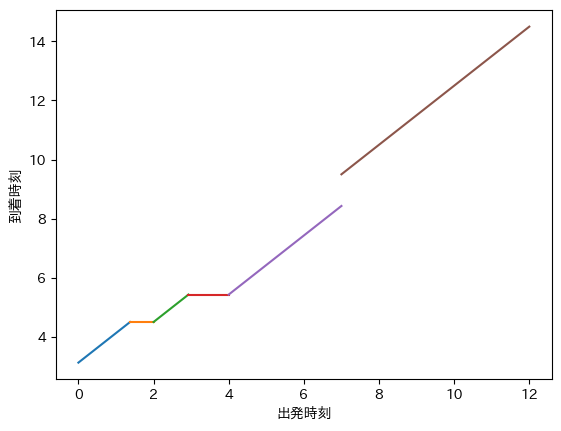

edge s -> 2
interval, b, a is [0, 1.625, 2, 3.3571428571428568, 4, 7] [1.875, 3.5, 3.5, 4.857142857142857, 4.857142857142857, 8.5] [1, 0, 1, 0, 1, 1]


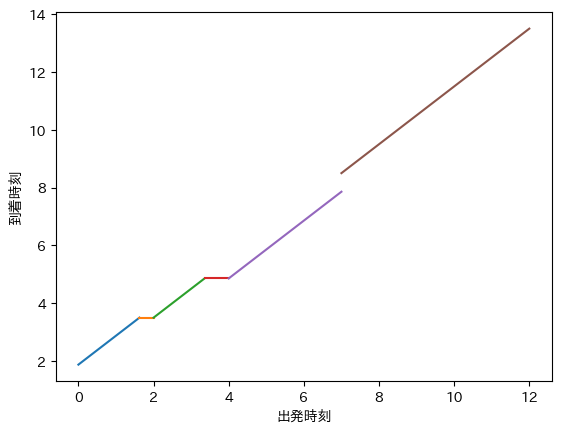

edge 1 -> 2
interval, b, a is [0, 1.75, 2, 3.571428571428571, 4, 7] [1.25, 3.0, 3.0, 4.571428571428571, 4.571428571428571, 8.0] [1, 0, 1, 0, 1, 1]


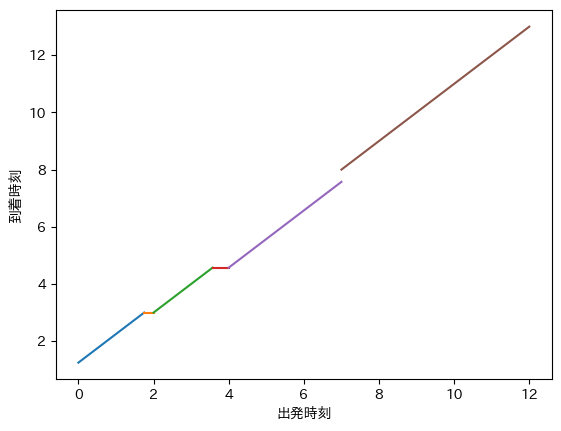

edge 1 -> t
interval, b, a is [0, 1.0, 2, 2.2857142857142856, 4, 7] [5.0, 6.0, 6.0, 6.285714285714286, 6.285714285714286, 11.0] [1, 0, 1, 0, 1, 1]


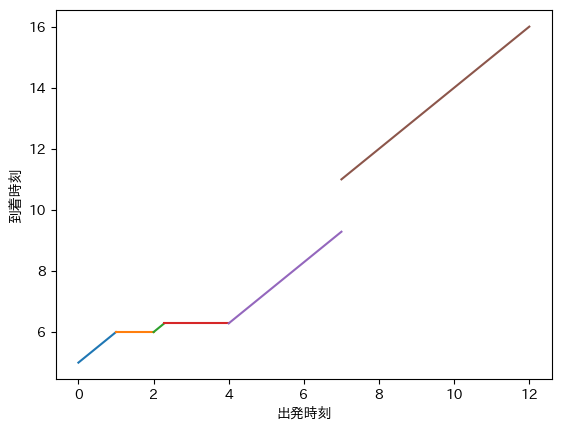

edge 2 -> 3
interval, b, a is [0, 1.375, 2, 2.928571428571429, 4, 7] [3.125, 4.5, 4.5, 5.428571428571429, 5.428571428571429, 9.5] [1, 0, 1, 0, 1, 1]


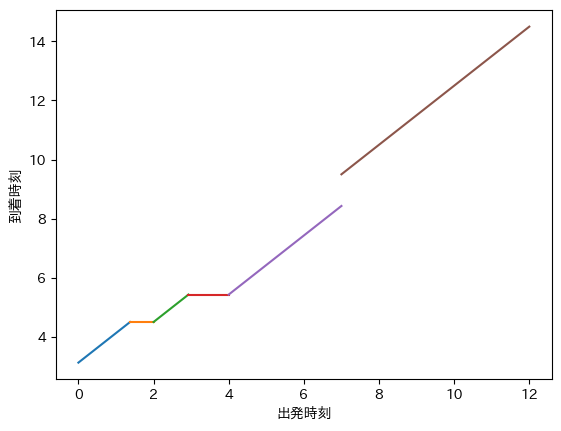

edge t -> 3
interval, b, a is [0, 1.25, 2, 2.7142857142857144, 4, 7] [3.75, 5.0, 5.0, 5.714285714285714, 5.714285714285714, 10.0] [1, 0, 1, 0, 1, 1]


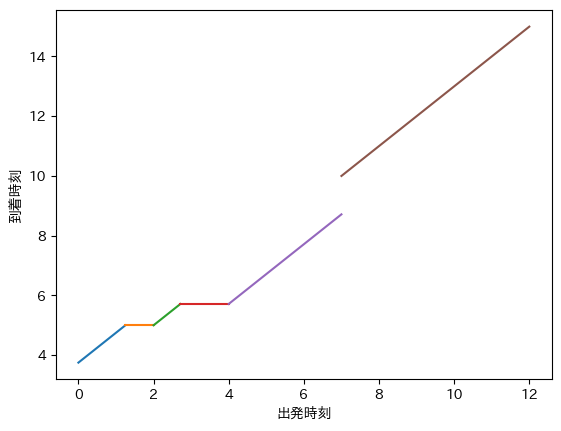

In [ ]:
for i, j in G.edges:
    interval, b, a = G[i][j]["piecewise"]
    print(f"edge {i} -> {j}")
    print("interval, b, a is", interval, b, a)
    plot_arrival(interval, b, a)

In [37]:
source = "s"
target = "t"
G_succ = G.succ if G.is_directed() else G.adj
pred = {source: []}
paths = {source: [source]}

push = heappush
pop = heappop
dist = {}  # dictionary of final distances
seen = {source: 0}
c = count()
fringe = []  # use heapq with (distance,label) tuples
push(fringe, (0, next(c), source))
while fringe:
    (d, _, v) = pop(fringe)
    if v in dist:
        continue  # already searched this node.
    dist[v] = d
    if v == target:
        break

    for u, e in G_succ[v].items():
        interval, b, a = G[v][u]["piecewise"]
        vu_dist = arrival(dist[v], interval, b, a)
        if u in dist:
            if vu_dist < dist[u]:
                raise ValueError("Contradictory paths found:", "negative weights?")
        elif u not in seen or vu_dist < seen[u]:
            seen[u] = vu_dist
            push(fringe, (vu_dist, next(c), u))
            if paths is not None:
                paths[u] = paths[v] + [u]
            if pred is not None:
                pred[u] = [v]
        elif vu_dist == seen[u]:
            if pred is not None:
                pred[u].append(v)
print(pred)
print(dist)

{'s': [], 1: [2], 2: ['s'], 3: [2], 't': [3]}
{'s': 0, 2: 1.875, 1: 3.0, 3: 4.5, 't': 6.214285714285714}
